
EE4414 Team Practice
==============================================

In this team practice, you will design Convolutional Neural Network(s) to classify food images.




In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import models, transforms
from torchvision.datasets.folder import make_dataset
from PIL import Image
import matplotlib.pyplot as plt
import time
import os
import copy
from torchsummary import summary

plt.ion()   # interactive mode
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# 1. Baseline ResNet34 

## 1. Loading data

Define the dataset, dataloader, and the data augmentation pipeline.

The code below loads 5 classes from all 12 classes in the dataset. You need to modify it to load only the classes that you need.

***Note: For correctly assessing your code, do not change the file structure of the dataset. Use Pytorch data loading utility (`torch.utils.data`) for customizing your dataset.***

In [3]:
# Define the dataset class
class sg_food_dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, root, class_id, transform=None):
        self.class_id = class_id
        self.root = root
        all_classes = sorted(entry.name for entry in os.scandir(root) if entry.is_dir())
        if not all_classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")
        self.classes = [all_classes[x] for x in class_id]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.samples = make_dataset(self.root, self.class_to_idx, extensions=('jpg'))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        with open(path, "rb") as f:
            sample = Image.open(f).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target


The last digit of the matriculation number: 3, 3, 1, 0, 7 

The classes we selected: 0, 1, 2, 3, 7

In [4]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
    'val': transforms.Compose([
        # Define data preparation operations for testing/validation set here.
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
}

data_dir = os.path.join('data', 'sg_food')
subfolder = {'train': 'train', 'val': 'val'}

# Define the dataset
selected_classes = [0,1,2,3,7]
n_classes = len(selected_classes)
image_datasets = {x: sg_food_dataset(root=os.path.join(data_dir, subfolder[x]),
                                     class_id=selected_classes,
                                     transform=data_transforms[x]) 
                  for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print('selected classes:\n    id: {}\n    name: {}'.format(selected_classes, class_names))

# Define the dataloader
batch_size = 16
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(f'dataset_sizes: {dataset_sizes}')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {torch.cuda.get_device_name(0)}')


selected classes:
    id: [0, 1, 2, 3, 7]
    name: ['Bak Chor Mee', 'Char Kway Teow', 'Chicken Rice', 'Hokkien Prawn Mee', 'Oyster Omelette']
dataset_sizes: {'train': 500, 'val': 150}
Device: NVIDIA GeForce RTX 2070 with Max-Q Design


## 2. Visualizing the dataset
Fetch a batch of training data from the dataset and visualize them. 



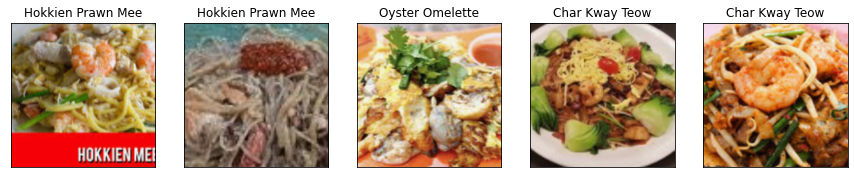

In [5]:
def im_convert(tensor):
    
    inp = tensor.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    return inp

fig=plt.figure(figsize=(15, 15))
columns = 5
rows = 1

dataiter = iter(dataloaders['val'])
inputs, classes = dataiter.next()

for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    ax.set_title(class_names[int(classes[idx])])
    plt.imshow(im_convert(inputs[idx]))
plt.show()

## 3. Defining function to train the model

Use a pre-trained CNN model with transfer learning techniques to classify the 5 food categories.

(Note: The provided code is only for reference. You can modify the code whichever way you want.)


In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()
    final_train_loss = []
    final_train_acc = []
    final_val_loss = []
    final_val_acc =[]

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()  

            running_loss = 0.0
            running_corrects = 0

  
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

  
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                final_train_loss.append(epoch_loss)
                final_train_acc.append(epoch_acc)
            else:
                final_val_loss.append(epoch_loss)
                final_val_acc.append(epoch_acc)
                
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    x = [i for i in range(1,num_epochs+1)]
    plt.figure(figsize=(15,9))
    plt.plot(x,final_train_loss,label="train loss",color="red",linewidth=2)
    plt.plot(x,final_val_loss,label="val loss",color="blue",linewidth=2)
    plt.xlabel("epoch") 
    plt.legend()
    plt.show()  
    

    model.load_state_dict(best_model_wts)
    return model

## 4. Training and validating the model

Train your model for minimum 3 epochs.

### 4.1 Loading pretrained model and defining new classfier layer


In [9]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        model = model
        for param in model.parameters():    
            param.requires_grad = False

def alexnet(num_classes, feature_extract = False):

    model_ft = models.alexnet(pretrained=True)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, num_classes))

    return model_ft

learning_rate = 1e-4
weight_decay = 1e-3
num_epoch = 20

model = res_model(5)
model = model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=20)

### 4.2 Printing and visualizing the modified model

In [10]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
summary(model, input_size=(1,3,256,256))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  36,864
|    |    └─BatchNorm2d: 3-10            128
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 36,864
|    |    └─BatchNorm2d: 3-12            128
|    |    └─ReLU: 3-13                   -

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  36,864
|    |    └─BatchNorm2d: 3-10            128
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 36,864
|    |    └─BatchNorm2d: 3-12            128
|    |    └─ReLU: 3-13                   -

### 4.3 Training using train data and evaluating using validation data

Train your model for minimum 3 epochs.

Epoch 0/19
----------


C:\Users\boyu_\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 1.1952 Acc: 0.5400
val Loss: 0.6431 Acc: 0.7600

Epoch 1/19
----------
train Loss: 0.6282 Acc: 0.7840
val Loss: 0.4577 Acc: 0.8600

Epoch 2/19
----------
train Loss: 0.4475 Acc: 0.8560
val Loss: 0.4285 Acc: 0.8467

Epoch 3/19
----------
train Loss: 0.3941 Acc: 0.8740
val Loss: 0.3828 Acc: 0.8867

Epoch 4/19
----------
train Loss: 0.3011 Acc: 0.9100
val Loss: 0.4353 Acc: 0.8600

Epoch 5/19
----------
train Loss: 0.3225 Acc: 0.8880
val Loss: 0.4057 Acc: 0.8600

Epoch 6/19
----------
train Loss: 0.3142 Acc: 0.8880
val Loss: 0.4095 Acc: 0.8800

Epoch 7/19
----------
train Loss: 0.2618 Acc: 0.9180
val Loss: 0.4180 Acc: 0.8800

Epoch 8/19
----------
train Loss: 0.2721 Acc: 0.9080
val Loss: 0.4086 Acc: 0.8733

Epoch 9/19
----------
train Loss: 0.2459 Acc: 0.9260
val Loss: 0.3457 Acc: 0.8733

Epoch 10/19
----------
train Loss: 0.1924 Acc: 0.9480
val Loss: 0.3378 Acc: 0.8867

Epoch 11/19
----------
train Loss: 0.1846 Acc: 0.9340
val Loss: 0.3662 Acc: 0.9133

Epoch 12/19
----------
t

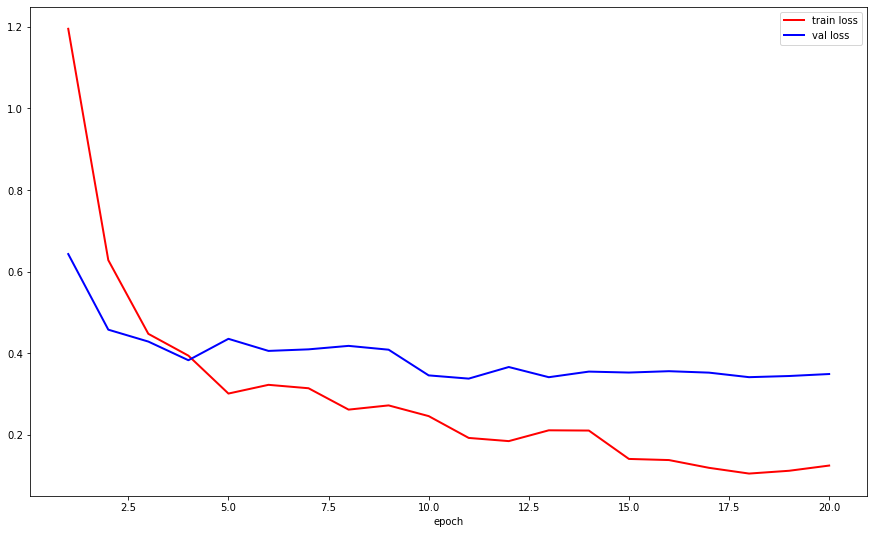

In [12]:
model_resnet34 = train_model(model, criterion, optimizer, scheduler, num_epochs = 20)

2653 MB GPU used by ResNet34

## 5. Loading test data

Define the dataset and dataloader for testing.

In [10]:
test_dir = os.path.join('data', 'sg_food', 'test')

# Define the test set.
test_dataset = sg_food_dataset(root=test_dir, class_id=selected_classes, transform=data_transforms['val'])
test_sizes = len(test_dataset)

# Define the dataloader for testing.
test_batch_size = 64
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=0)

## 6. Visualizing the predictions

Predict the label on a few testing samples and visualize the results.

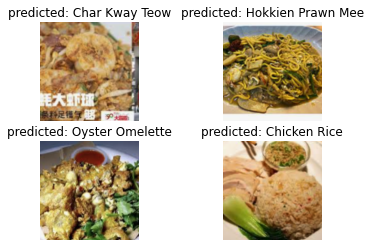

In [14]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                plt.imshow(im_convert(inputs.cpu().data[j]))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


visualize_model(model_resnet34)
plt.show()


## 7. Evaluating on test set

Evaluate your model on the whole test set and compute the accuracy.

In [15]:
model_resnet34.eval()

test_acc = 0

print('Evaluation')
print('-' * 10)

with torch.no_grad():
    # Iterate over the testing dataset.
    for (inputs, labels) in test_loader:
        inputs = inputs.to(device)
        # Predict on the test set
        outputs = model_resnet34(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu()
        test_acc += torch.sum(preds == labels.data)

# Compute the testing accuracy
test_acc = test_acc.double() / test_sizes
print('Testing Acc: {:.4f}'.format(test_acc))


Evaluation
----------
Testing Acc: 0.8680


# 2. Improve Accuracy: ResNeSt+ResNeXt+ConvNext

## 1. ResNeSt

In [23]:
from resnest.torch import resnest50

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        model = model
        for param in model.parameters():
            param.requires_grad = False

def resnest_model(num_classes, feature_extract = False):
    model_ft = resnest50(pretrained=True)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, num_classes))

    return model_ft

learning_rate = 1e-4
weight_decay = 1e-3
num_epoch = 20

model = resnest_model(5)
model = model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=20)
summary(model, input_size=(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           9,216
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              ReLU-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 64, 128, 128]          18,432
       BatchNorm2d-8         [-1, 64, 128, 128]             128
              ReLU-9         [-1, 64, 128, 128]               0
        MaxPool2d-10           [-1, 64, 64, 64]               0
           Conv2d-11           [-1, 64, 64, 64]           4,096
      BatchNorm2d-12           [-1, 64, 64, 64]             128
             ReLU-13           [-1, 64, 64, 64]               0
           Conv2d-14          [-1, 128,

Epoch 0/19
----------
train Loss: 1.2922 Acc: 0.4900
val Loss: 0.7498 Acc: 0.7533

Epoch 1/19
----------
train Loss: 0.7723 Acc: 0.7160
val Loss: 0.7550 Acc: 0.7467

Epoch 2/19
----------
train Loss: 0.5068 Acc: 0.8320
val Loss: 0.4478 Acc: 0.8533

Epoch 3/19
----------
train Loss: 0.4941 Acc: 0.8180
val Loss: 0.4760 Acc: 0.8467

Epoch 4/19
----------
train Loss: 0.3866 Acc: 0.8580
val Loss: 0.4449 Acc: 0.8267

Epoch 5/19
----------
train Loss: 0.3718 Acc: 0.8680
val Loss: 0.5028 Acc: 0.8267

Epoch 6/19
----------
train Loss: 0.3593 Acc: 0.8740
val Loss: 0.3662 Acc: 0.8800

Epoch 7/19
----------
train Loss: 0.2901 Acc: 0.9000
val Loss: 0.3725 Acc: 0.8667

Epoch 8/19
----------
train Loss: 0.2228 Acc: 0.9220
val Loss: 0.2995 Acc: 0.9000

Epoch 9/19
----------
train Loss: 0.2201 Acc: 0.9260
val Loss: 0.2966 Acc: 0.9067

Epoch 10/19
----------
train Loss: 0.2007 Acc: 0.9400
val Loss: 0.3361 Acc: 0.8800

Epoch 11/19
----------
train Loss: 0.2306 Acc: 0.9160
val Loss: 0.3021 Acc: 0.9133

Ep

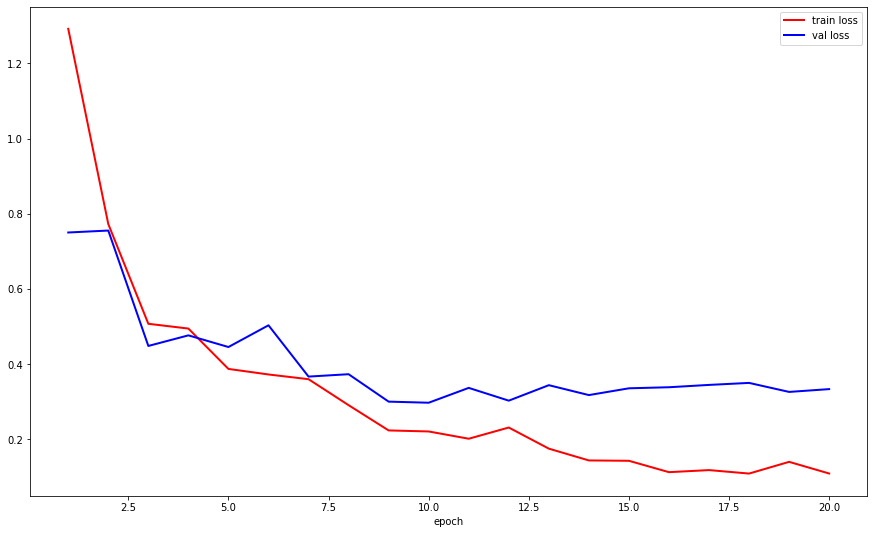

In [24]:
model_resnest50 = train_model(model, criterion, optimizer, scheduler, num_epochs = 20)

6777 MB GPU used by ResNest50

In [25]:
model_resnest50.eval()

test_acc = 0

print('Evaluation')
print('-' * 10)

with torch.no_grad():
    # Iterate over the testing dataset.
    for (inputs, labels) in test_loader:
        inputs = inputs.to(device)
        # Predict on the test set
        outputs = model_resnest50(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu()
        test_acc += torch.sum(preds == labels.data)

# Compute the testing accuracy
test_acc = test_acc.double() / test_sizes
print('Testing Acc: {:.4f}'.format(test_acc))


Evaluation
----------
Testing Acc: 0.9020


# 2. ResNeXt

In [26]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        model = model
        for param in model.parameters():
            param.requires_grad = False

def resnext_model(num_classes, feature_extract = False):

    model_ft = models.resnext50_32x4d(pretrained=True)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, num_classes))

    return model_ft

learning_rate = 1e-4
weight_decay = 1e-3
num_epoch = 20

model = resnext_model(5)
model = model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=20)
summary(model, input_size=(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5          [-1, 128, 64, 64]           8,192
       BatchNorm2d-6          [-1, 128, 64, 64]             256
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]           4,608
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          32,768
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

Epoch 0/19
----------
train Loss: 1.0836 Acc: 0.6180
val Loss: 0.6118 Acc: 0.8200

Epoch 1/19
----------
train Loss: 0.4583 Acc: 0.8540
val Loss: 0.3968 Acc: 0.8933

Epoch 2/19
----------
train Loss: 0.4955 Acc: 0.8120
val Loss: 0.5022 Acc: 0.8733

Epoch 3/19
----------
train Loss: 0.4044 Acc: 0.8620
val Loss: 0.5950 Acc: 0.8667

Epoch 4/19
----------
train Loss: 0.3420 Acc: 0.8860
val Loss: 0.5612 Acc: 0.8867

Epoch 5/19
----------
train Loss: 0.2832 Acc: 0.9000
val Loss: 0.4436 Acc: 0.8667

Epoch 6/19
----------
train Loss: 0.2739 Acc: 0.9180
val Loss: 0.5022 Acc: 0.8600

Epoch 7/19
----------
train Loss: 0.2577 Acc: 0.9000
val Loss: 0.5356 Acc: 0.8667

Epoch 8/19
----------
train Loss: 0.2353 Acc: 0.9040
val Loss: 0.4952 Acc: 0.8733

Epoch 9/19
----------
train Loss: 0.1984 Acc: 0.9240
val Loss: 0.4572 Acc: 0.8733

Epoch 10/19
----------
train Loss: 0.1855 Acc: 0.9320
val Loss: 0.4772 Acc: 0.8933

Epoch 11/19
----------
train Loss: 0.1490 Acc: 0.9500
val Loss: 0.4145 Acc: 0.9133

Ep

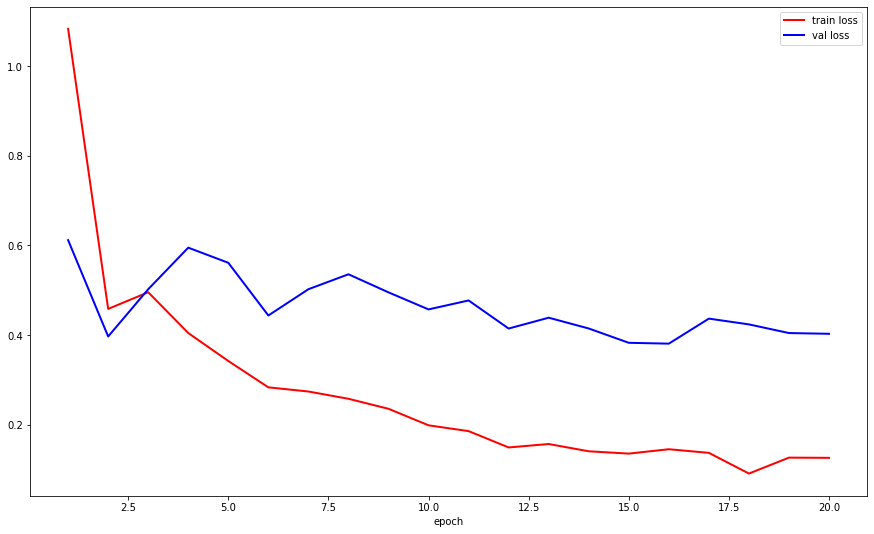

In [27]:
model_resnext50 = train_model(model, criterion, optimizer, scheduler, num_epochs = 20)

5673 MB GPU used by ResNeXt50

In [28]:
model_resnext50.eval()

test_acc = 0

print('Evaluation')
print('-' * 10)

with torch.no_grad():
    # Iterate over the testing dataset.
    for (inputs, labels) in test_loader:
        inputs = inputs.to(device)
        # Predict on the test set
        outputs = model_resnext50(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu()
        test_acc += torch.sum(preds == labels.data)

# Compute the testing accuracy
test_acc = test_acc.double() / test_sizes
print('Testing Acc: {:.4f}'.format(test_acc))

Evaluation
----------
Testing Acc: 0.8980


## 3. ConvNext

In [5]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        model = model
        for param in model.parameters():
            param.requires_grad = False

def convnext_model(num_classes, feature_extract = False):

    model_ft = models.convnext_small(pretrained=True)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[-1].in_features
    model_ft.classifier[-1] = nn.Sequential(nn.Linear(num_ftrs, num_classes))

    return model_ft

learning_rate = 1e-4
weight_decay = 1e-3
num_epoch = 20

model = convnext_model(5)
model = model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=20)
summary(model, input_size=(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 64, 64]           4,704
       LayerNorm2d-2           [-1, 96, 64, 64]             192
            Conv2d-3           [-1, 96, 64, 64]           4,800
           Permute-4           [-1, 64, 64, 96]               0
         LayerNorm-5           [-1, 64, 64, 96]             192
            Linear-6          [-1, 64, 64, 384]          37,248
              GELU-7          [-1, 64, 64, 384]               0
            Linear-8           [-1, 64, 64, 96]          36,960
           Permute-9           [-1, 96, 64, 64]               0
  StochasticDepth-10           [-1, 96, 64, 64]               0
          CNBlock-11           [-1, 96, 64, 64]               0
           Conv2d-12           [-1, 96, 64, 64]           4,800
          Permute-13           [-1, 64, 64, 96]               0
        LayerNorm-14           [-1, 64,

Epoch 0/19
----------
train Loss: 1.1418 Acc: 0.5680
val Loss: 0.6056 Acc: 0.7867

Epoch 1/19
----------
train Loss: 0.6408 Acc: 0.8040
val Loss: 0.4688 Acc: 0.8000

Epoch 2/19
----------
train Loss: 0.4831 Acc: 0.8300
val Loss: 0.4603 Acc: 0.8867

Epoch 3/19
----------
train Loss: 0.3414 Acc: 0.8820
val Loss: 0.3090 Acc: 0.9200

Epoch 4/19
----------
train Loss: 0.2466 Acc: 0.9240
val Loss: 0.3292 Acc: 0.9000

Epoch 5/19
----------
train Loss: 0.2461 Acc: 0.9260
val Loss: 0.2912 Acc: 0.9067

Epoch 6/19
----------
train Loss: 0.1541 Acc: 0.9600
val Loss: 0.2667 Acc: 0.9067

Epoch 7/19
----------
train Loss: 0.1415 Acc: 0.9640
val Loss: 0.3178 Acc: 0.9133

Epoch 8/19
----------
train Loss: 0.1934 Acc: 0.9440
val Loss: 0.5269 Acc: 0.8467

Epoch 9/19
----------
train Loss: 0.1897 Acc: 0.9440
val Loss: 0.4982 Acc: 0.8600

Epoch 10/19
----------
train Loss: 0.1573 Acc: 0.9440
val Loss: 0.3566 Acc: 0.9200

Epoch 11/19
----------
train Loss: 0.1279 Acc: 0.9600
val Loss: 0.2604 Acc: 0.9400

Ep

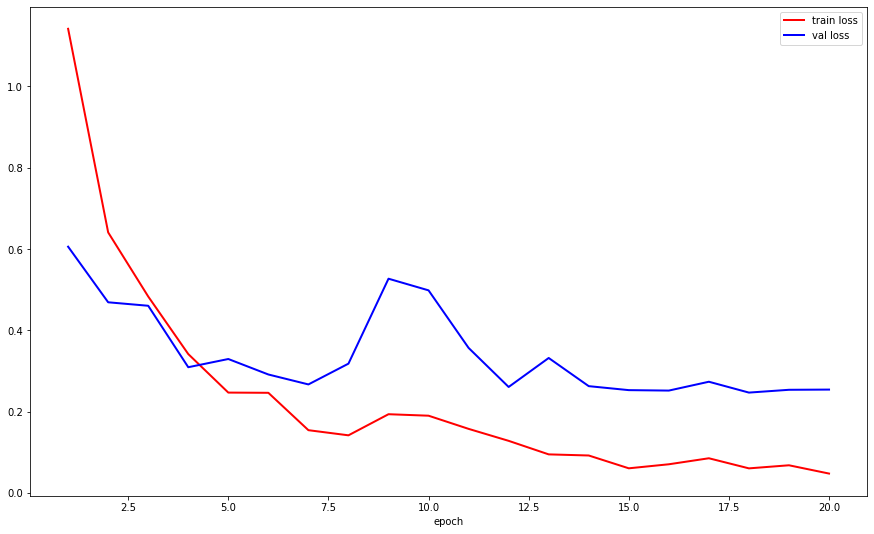

In [8]:
model_convnext = train_model(model, criterion, optimizer, scheduler, num_epochs = 20)

In [29]:
model_convnext.eval()

test_acc = 0

print('Evaluation')
print('-' * 10)

with torch.no_grad():
    # Iterate over the testing dataset.
    for (inputs, labels) in test_loader:
        inputs = inputs.to(device)
        # Predict on the test set
        outputs = model_convnext(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu()
        test_acc += torch.sum(preds == labels.data)

# Compute the testing accuracy
test_acc = test_acc.double() / test_sizes
print('Testing Acc: {:.4f}'.format(test_acc))

Evaluation
----------
Testing Acc: 0.9250


5023 MB GPU used by ConvNext, batch size = 16

## 4. Final result integration (voting)

In [30]:
model_resnest50.eval()
model_resnext50.eval()
model_convnext.eval()

test_acc = 0

print('Evaluation')
print('-' * 10)

with torch.no_grad():
    # Iterate over the testing dataset.
    for (inputs, labels) in test_loader:
        inputs = inputs.to(device)
        # Predict on the test set
        resnest_output = model_resnest50(inputs)
        resnext_output = model_resnext50(inputs)
        convnext_output = model_convnext(inputs)
        
        _, resnest_preds = torch.max(resnest_output, 1)
        _, resnext_preds = torch.max(resnext_output, 1)
        _, convnext_preds = torch.max(convnext_output, 1)
        
        resnest_preds = resnest_preds.cpu()
        resnext_preds = resnext_preds.cpu()
        convnext_preds = convnext_preds.cpu()
        
        preds = convnext_preds.clone()
        for i in range(len(convnext_preds)):
            if resnest_preds[i] == resnext_preds[i]:
                preds[i] = resnest_preds[i]
        
        
        test_acc += torch.sum(preds == labels.data)

# Compute the testing accuracy
test_acc = test_acc.double() / test_sizes
print('Testing Acc: {:.4f}'.format(test_acc))

Evaluation
----------
Testing Acc: 0.9250


# 3. Reduce the storage: EfficientNet

In [36]:
model_ft = models.efficientnet_b0(pretrained=True)
print(model_ft)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to C:\Users\boyu_/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-3dd342df.pth
100.0%


EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [39]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        model = model
        for param in model.parameters():
            param.requires_grad = False

def efficient_model(num_classes, feature_extract = False):

    model_ft = models.efficientnet_b0(pretrained=True)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[-1].in_features
    model_ft.classifier[-1] = nn.Sequential(nn.Linear(num_ftrs, num_classes))

    return model_ft

learning_rate = 1e-4
weight_decay = 1e-3
num_epoch = 20

model = efficient_model(5)
model = model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=20)
summary(model, input_size=(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              SiLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              SiLU-6         [-1, 32, 128, 128]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 128, 128]               0
           Conv2d-13         [-1, 16, 128, 128]             512
      BatchNorm2d-14         [-1, 16, 1

Epoch 0/19
----------
train Loss: 1.5237 Acc: 0.3860
val Loss: 1.3242 Acc: 0.6400

Epoch 1/19
----------
train Loss: 1.2593 Acc: 0.6140
val Loss: 0.9809 Acc: 0.7667

Epoch 2/19
----------
train Loss: 1.0465 Acc: 0.6640
val Loss: 0.7476 Acc: 0.8000

Epoch 3/19
----------
train Loss: 0.8131 Acc: 0.7200
val Loss: 0.6145 Acc: 0.8200

Epoch 4/19
----------
train Loss: 0.7142 Acc: 0.7640
val Loss: 0.5068 Acc: 0.8733

Epoch 5/19
----------
train Loss: 0.5681 Acc: 0.8360
val Loss: 0.4649 Acc: 0.8800

Epoch 6/19
----------
train Loss: 0.4803 Acc: 0.8580
val Loss: 0.4225 Acc: 0.8800

Epoch 7/19
----------
train Loss: 0.4572 Acc: 0.8560
val Loss: 0.3766 Acc: 0.8667

Epoch 8/19
----------
train Loss: 0.4004 Acc: 0.8720
val Loss: 0.3839 Acc: 0.8933

Epoch 9/19
----------
train Loss: 0.4054 Acc: 0.8820
val Loss: 0.3883 Acc: 0.9000

Epoch 10/19
----------
train Loss: 0.3877 Acc: 0.8760
val Loss: 0.3894 Acc: 0.8867

Epoch 11/19
----------
train Loss: 0.3895 Acc: 0.8680
val Loss: 0.3738 Acc: 0.8867

Ep

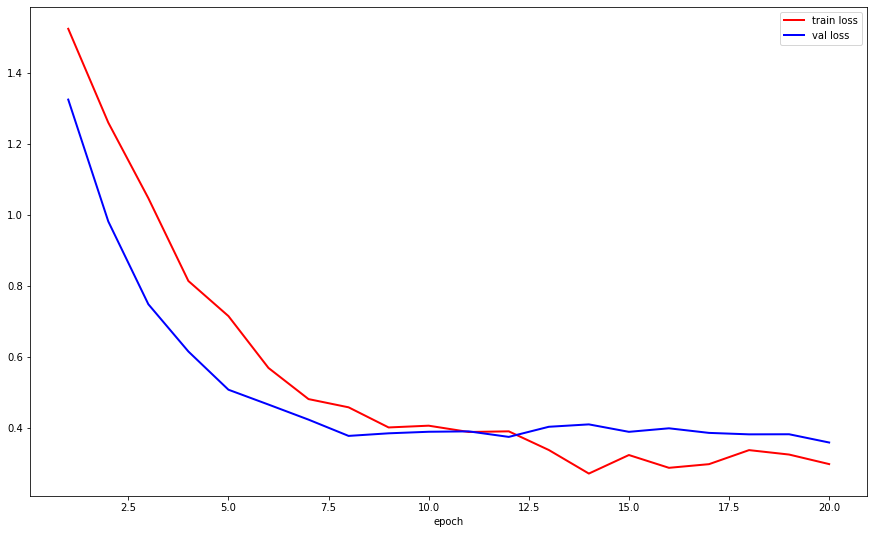

In [40]:
model_efficient = train_model(model, criterion, optimizer, scheduler, num_epochs = 20)

In [41]:
model_efficient.eval()

test_acc = 0

print('Evaluation')
print('-' * 10)

with torch.no_grad():
    # Iterate over the testing dataset.
    for (inputs, labels) in test_loader:
        inputs = inputs.to(device)
        # Predict on the test set
        outputs = model_efficient(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu()
        test_acc += torch.sum(preds == labels.data)

# Compute the testing accuracy
test_acc = test_acc.double() / test_sizes
print('Testing Acc: {:.4f}'.format(test_acc))

Evaluation
----------
Testing Acc: 0.8850


# 4.  Two classes classification
Cases where the test food images do not belong to any of the 5 target food categories